# Activity Analysis: Ra-224 Decay Tracking

This notebook demonstrates **activity analysis** for time-resolved alpha spectra:

1. **Load time-stamped spectra** from individual sets (not aggregated)
2. **Extract Ra-224 counts** using existing isotope range derivation
3. **Calculate activity** [Bq] from count rates (with efficiency/branching corrections)
4. **Fit decay curve** to measure Ra-224 half-life
5. **Visualize** activity evolution over ~2 days

## Physics Background

**Th-232 Decay Chain:**
```
Th-228 (1.9 y) --α(5.42 MeV)--> Ra-224 (3.6 d) --α(5.69 MeV)--> Rn-220 (55 s) --> ...
```

**Why Ra-224?**
- T½ = 3.66 days → Observable decay over 2-day measurement window
- Second peak in spectrum (5.69 MeV)
- Branching ratio: 94.9% (main α line)

**RUN18 Dataset:**
- 12 measurement sets (FieldScan_Gate0050_Anode1950, etc.)
- Each set: ~4-5 hours acquisition
- Total time span: ~2 days (Nov 4-6, 2025)
- Expected Ra-224 decay: ~40% over this period

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from RaTag.core.datatypes import Run
from RaTag.workflows.run_construction import initialize_run

from RaTag.workflows.spectrum_calibration import load_computed_ranges

# Spectrum fitting (reuse existing functions!)
from RaTag.alphas.spectrum_fitting import (
    load_spectrum_from_run,
    fit_multi_crystalball_progressive,
    derive_energy_calibration,
    derive_isotope_ranges,
    IsotopeRange,
)

# Activity analysis (new module)
from RaTag.alphas.activity_analysis import (
    load_timestamped_spectrum,
    load_all_timestamped_spectra,
    measure_activity,
    measure_activity_timeseries,
    fit_exponential_decay,
    HALF_LIVES,
    BRANCHING_RATIOS,
)

# Activity plotting (new module)
from RaTag.alphas.activity_plotting import (
    plot_activity_timeseries,
    plot_count_rate_timeseries,
    plot_activity_diagnostic,
)

## Step 1: Initialize Run and Load First Spectrum for Calibration

We need to derive isotope ranges first (using aggregated spectrum for better statistics).

In [3]:
# Define run
path_multi = Path('/Volumes/KINGSTON/RaTag_data/RUN18')

run = Run(
    run_id="RUN18",
    root_directory=path_multi,
    target_isotope="Multi",
    pressure=2.0,
    temperature=297.0,
    sampling_rate=5.0,
    drift_gap=1.4,
    el_gap=0.8,
    el_field=2375.0,
    sets=[]
)

# Initialize (populates sets, computes fields)
run = initialize_run(run)

print(f"Loaded run with {len(run.sets)} sets")
for i, s in enumerate(run.sets):
    print(f"  Set {i}: {s.source_dir.name}")


RUN INITIALIZATION

[1/3] Gas density...
  ✓ Gas density: 4.877e+19 cm⁻³

[2/3] Populating sets...
Detected multi-isotope files...
  Loaded: FieldScan_Gate0050_Anode1950 - 3800 files (182400 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0050_Anode1950 - 3800 files (182400 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0100_Anode2000 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0100_Anode2000 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0200_Anode2100 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0200_Anode2100 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0300_Anode2200 - 4000 files (192000 waveforms) [Fast

## Step 2: Derive Isotope Ranges (Reuse Existing Pipeline)

Use aggregated spectrum for accurate peak fitting and calibration.

In [4]:
# Load aggregated spectrum for calibration
spectrum_aggregated = load_spectrum_from_run(run, energy_range=(4, 8.2), aggregate=True)
energies, counts = spectrum_aggregated.select_roi()

print(f"Aggregated spectrum: {len(spectrum_aggregated.energies):,} events")

Aggregated spectrum: 2,036,160 events


In [5]:
# Fit main peaks (reuse existing pipeline)
peak_definitions = [
    {'name': 'Th228', 'position': 4.5, 'window': (4.0, 4.7), 'sigma_init': 0.15, 'ref_energy': 5.42315},
    {'name': 'Ra224', 'position': 4.8, 'window': (4.65, 5.1), 'sigma_init': 0.15, 'ref_energy': 5.68537},
    {'name': 'Rn220', 'position': 5.4, 'window': (5.0, 5.5), 'sigma_init': 0.15, 'ref_energy': 6.40484},
    {'name': 'Po216', 'position': 5.9, 'window': (5.6, 6.1), 'sigma_init': 0.15, 'ref_energy': 6.90628},
    {'name': 'Po212', 'position': 7.5, 'window': (6.3, 8.0), 'sigma_init': 0.15, 'ref_energy': 8.785},
]

fit_results = fit_multi_crystalball_progressive(energies, counts, 
                                                peak_definitions=peak_definitions, 
                                                global_beta_m=True)

print(f"\n✓ Fitted {len(fit_results)} peaks")

  ✓ Th228: x0=4.5726 MeV, σ=0.1089 MeV
  ✓ Ra224: x0=4.7539 MeV, σ=0.1343 MeV
  ✓ Rn220: x0=5.3055 MeV, σ=0.0836 MeV
  ✓ Po216: x0=5.7336 MeV, σ=0.0835 MeV
  ✓ Po212 (α+β): x0=7.5160 MeV, σ=0.1355 MeV

  Average tail params: β=-2.152, m=3.071

✓ Fitted 5 peaks


/Users/pabloherrero/sabat/RaTagging/RaTag/alphas/spectrum_fitting.py:264: RuntimeWarning: invalid value encountered in power
  tail = A_tail / (B - z)**m


In [6]:
# Derive energy calibration
literature_energies = {p['name']: p['ref_energy'] for p in peak_definitions}

calibration = derive_energy_calibration(fit_results, literature_energies,
                                       use_peaks=list(literature_energies.keys()), 
                                       order=2)  # Quadratic

print("\nEnergy Calibration (Quadratic):")
print(calibration)


Energy Calibration (Quadratic):
E_true [MeV] = -7.848972e-02 * E_SCA² + 2.087640 * E_SCA + -2.472739
Anchors: ['Th228', 'Ra224', 'Rn220', 'Po216', 'Po212']
RMS residual: 8.6 keV


## Step 2.5: Load Overlap-Resolved Isotope Ranges

**Critical**: We must use the **likelihood crossover** ranges that resolve the Th228/Ra224 overlap.

Simple windowing (μ ± nσ) creates overlap between Th228 and Ra224 peaks, which would contaminate our Ra224 activity measurement with long-lived Th228 events (T½ = 1.9 years).

The `load_computed_ranges()` function loads the Bayes-optimal boundaries computed during calibration.

In [42]:
ra224_E_min, ra224_E_max, 5.7

(np.float64(5.543481539115494), np.float64(6.03810416319886), 5.7)

In [43]:
# Load overlap-resolved isotope ranges from calibration workflow
# This uses the likelihood crossover method to resolve Th228/Ra224 overlap


isotope_ranges_dict = load_computed_ranges(run.run_id, run.root_directory)

print("\n" + "="*70)
print("ISOTOPE RANGES (Overlap-Resolved, Calibrated Energy)")
print("="*70)
for name, (E_min, E_max) in isotope_ranges_dict.items():
    print(f"{name:8s}: [{E_min:.3f}, {E_max:.3f}] MeV")
print("="*70)

# Extract Ra-224 range for activity analysis
ra224_E_min, ra224_E_max = isotope_ranges_dict['Ra224']

# Create IsotopeRange object for compatibility with measure_activity()
ra224_range = IsotopeRange(
    name='Ra224',
    # E_min=ra224_E_min,
    E_min=5.6,
    E_max=5.8,
    E_peak=literature_energies['Ra224'],
    sigma=(ra224_E_max - ra224_E_min) / 4,  # Approximate sigma
    purity=1.0
)

print(f"\n✓ Ra-224 range extracted: [{ra224_range.E_min:.3f}, {ra224_range.E_max:.3f}] MeV")
print(f"  (Using overlap-resolved boundary with Th228)")


ISOTOPE RANGES (Overlap-Resolved, Calibrated Energy)
Th228   : [5.134, 5.543] MeV
Ra224   : [5.543, 6.038] MeV
Rn220   : [6.184, 6.604] MeV
Po216   : [6.718, 7.115] MeV
Po212   : [8.538, 9.030] MeV

✓ Ra-224 range extracted: [5.600, 5.800] MeV
  (Using overlap-resolved boundary with Th228)


## Step 3: Load Time-Stamped Spectra (Per-Set, Not Aggregated)

Now load individual sets with timestamps from .wfm files.

In [44]:
# Load all time-stamped spectra (in SCA units)
timestamped_spectra = load_all_timestamped_spectra(run, energy_range=(4, 8.2))

# --- Apply quadratic calibration to each spectrum to convert to MeV ---
import numpy as np
calib_file = '/Volumes/KINGSTON/RaTag_data/RUN18/processed_data/spectrum_calibration/RUN18_calibration.npz'
calib_data = np.load(calib_file)
quad_a = calib_data['quad_a']
quad_b = calib_data['quad_b']
quad_c = calib_data['quad_c']

def apply_quadratic_calibration(x):
    return quad_a * x**2 + quad_b * x + quad_c

from RaTag.alphas.spectrum_fitting import SpectrumData
from RaTag.alphas.activity_analysis import TimeStampedSpectrum

calibrated_timestamped_spectra = []
for spectrum_t in timestamped_spectra:
    spectrum = spectrum_t.spectrum
    energies_cal = apply_quadratic_calibration(np.array(spectrum.energies))
    spectrum_cal = SpectrumData(
        energies=energies_cal,
        energy_range=(4, 8.2),  # Now in MeV
        source=spectrum.source
    )
    spectrum_t_cal = TimeStampedSpectrum(
        spectrum=spectrum_cal,
        timestamp=spectrum_t.timestamp,
        set_name=spectrum_t.set_name,
        acquisition_time=spectrum_t.acquisition_time
    )
    calibrated_timestamped_spectra.append(spectrum_t_cal)

timestamped_spectra = calibrated_timestamped_spectra

print(f"Loaded {len(timestamped_spectra)} time-stamped spectra and calibrated to MeV\n")
print("="*70)
print("TIMESTAMP OVERVIEW")
print("="*70)
for i, spectrum_t in enumerate(timestamped_spectra):
    n_events = len(spectrum_t.spectrum.energies)
    print(f"{i:2d}. {spectrum_t.set_name:35s} | {spectrum_t.acquisition_time} | {n_events:6,} events")
print("="*70)

# Time span
t_start = timestamped_spectra[0].acquisition_time
t_end = timestamped_spectra[-1].acquisition_time
duration_hours = (timestamped_spectra[-1].timestamp - timestamped_spectra[0].timestamp) / 3600

print(f"\nTime span: {t_start} → {t_end}")
print(f"Duration: {duration_hours:.1f} hours = {duration_hours/24:.2f} days")

Loaded 12 time-stamped spectra and calibrated to MeV

TIMESTAMP OVERVIEW
 0. FieldScan_Gate0050_Anode1950        | 2025-11-04 13:09:16 | 182,400 events
 1. FieldScan_Gate0100_Anode2000        | 2025-11-04 18:22:07 | 192,000 events
 2. FieldScan_Gate0200_Anode2100        | 2025-11-05 13:54:21 | 192,000 events
 3. FieldScan_Gate0300_Anode2200        | 2025-11-05 19:44:03 | 192,000 events
 4. FieldScan_Gate0400_Anode2300        | 2025-11-06 13:12:12 | 192,000 events
 5. FieldScan_Gate0500_Anode2400        | 2025-11-06 18:55:43 | 72,000 events
 6. FieldScan_Gate0600_Anode2500        | 2025-11-07 08:01:59 | 192,000 events
 7. FieldScan_Gate0700_Anode2600        | 2025-11-07 14:49:31 | 53,760 events
 8. FieldScan_Gate0800_Anode2700        | 2025-11-07 20:21:02 | 192,000 events
 9. FieldScan_Gate0900_Anode2800        | 2025-11-08 08:08:20 | 192,000 events
10. FieldScan_Gate1000_Anode2900        | 2025-11-08 13:54:25 | 192,000 events
11. FieldScan_Gate1200_Anode3100        | 2025-11-08 19:46:5

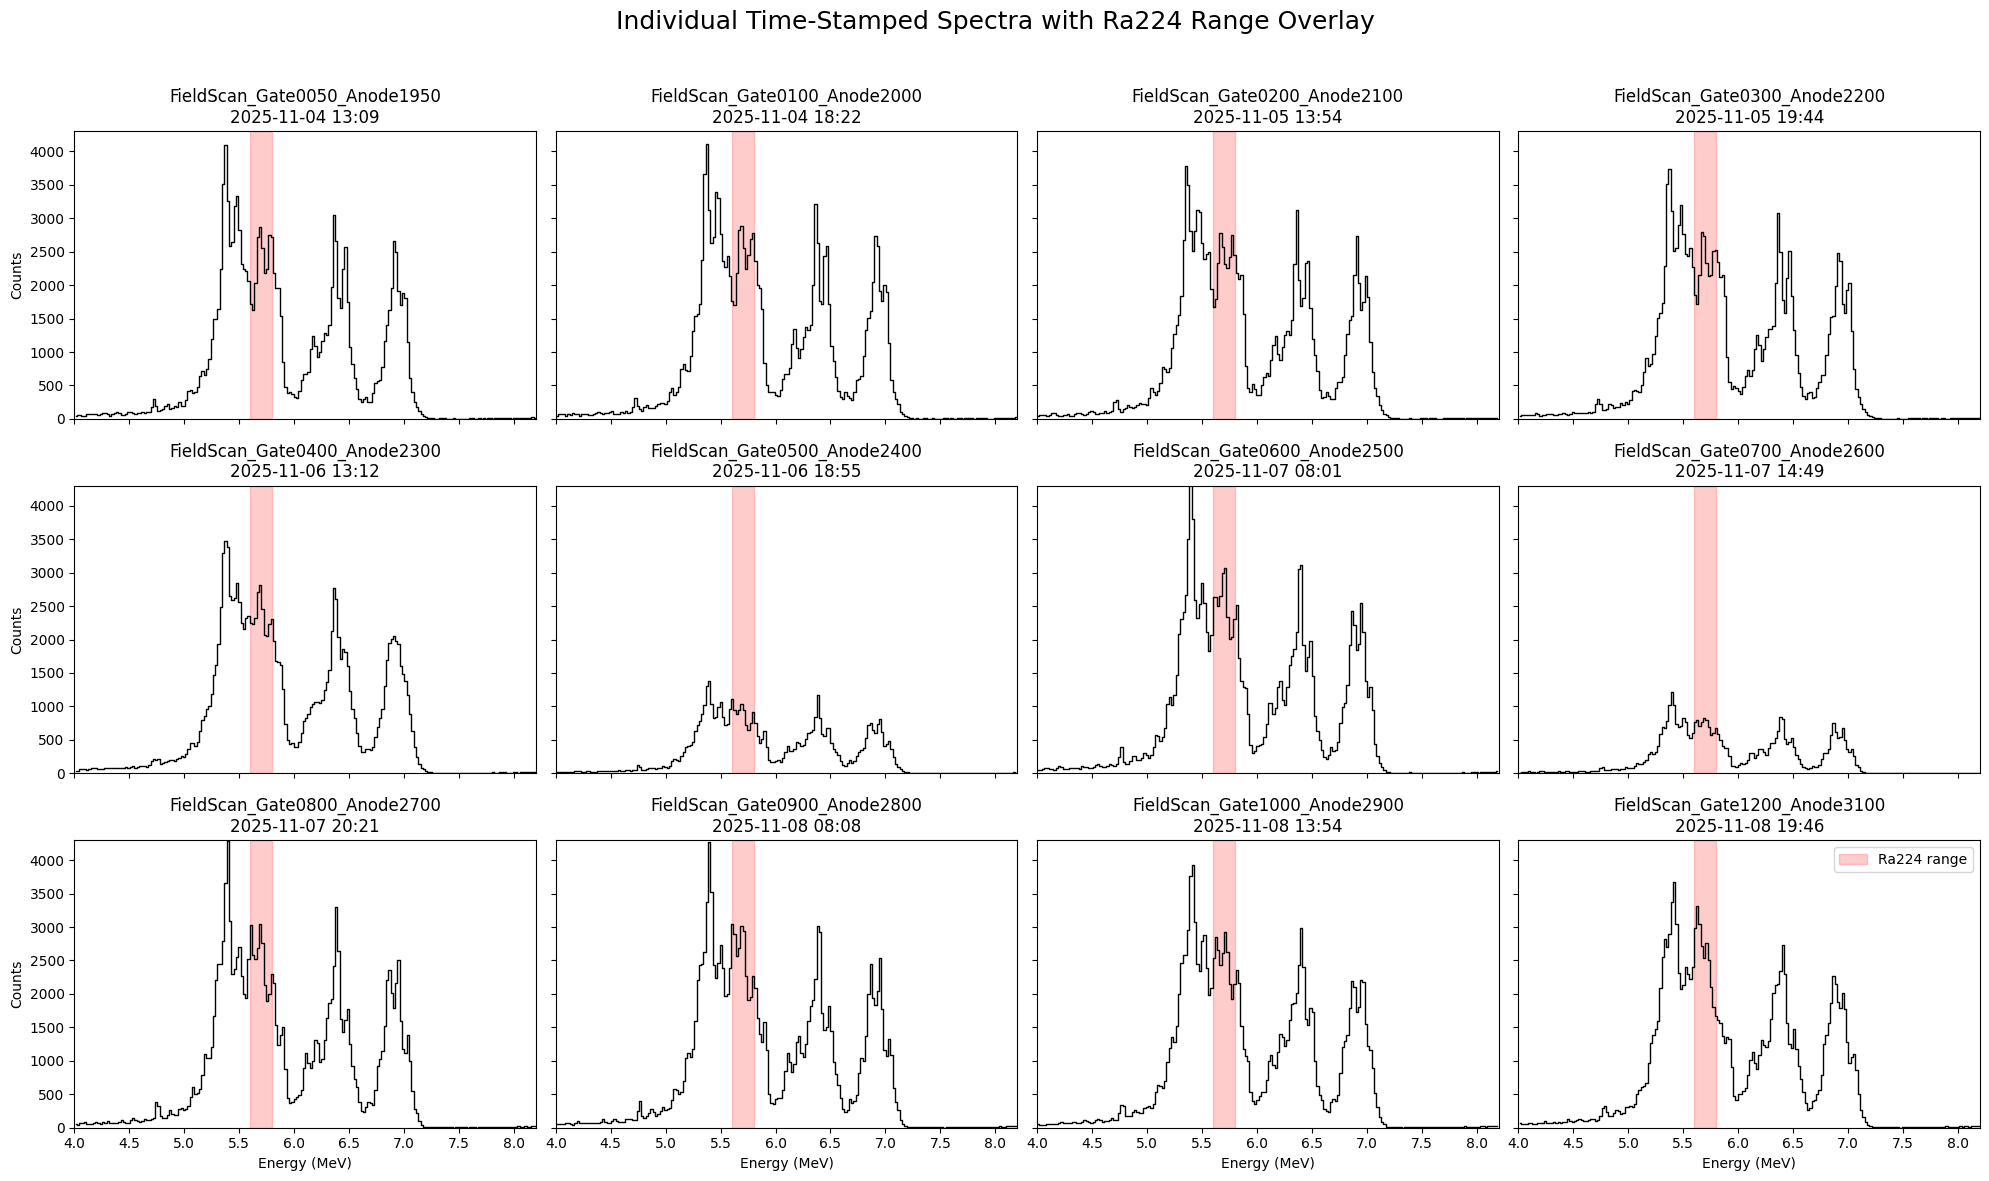


✓ Diagnostic: Plotted all individual spectra with Ra224 range overlay.


In [45]:
# --- DIAGNOSTIC: Check units and range mapping for timestamped spectra ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, spectrum_t in enumerate(timestamped_spectra):
    ax = axes[i]
    energies = spectrum_t.spectrum.energies
    counts, bins = np.histogram(energies, bins=200, range=(4, 8.2))
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    ax.step(bin_centers, counts, where='mid', color='k', lw=1)
    ax.set_title(f"{spectrum_t.set_name}\n{str(spectrum_t.acquisition_time)[:16]}")
    # Overlay Ra224 range (MeV)
    ax.axvspan(ra224_range.E_min, ra224_range.E_max, color='red', alpha=0.2, label='Ra224 range')
    ax.set_xlim(4, 8.2)
    ax.set_ylim(bottom=0)
    if i % 4 == 0:
        ax.set_ylabel('Counts')
    if i >= 8:
        ax.set_xlabel('Energy (MeV)')

plt.suptitle('Individual Time-Stamped Spectra with Ra224 Range Overlay', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.legend(loc='upper right')
plt.show()

print("\n✓ Diagnostic: Plotted all individual spectra with Ra224 range overlay.")

## Step 4: Measure Ra-224 Activity Time Series

Calculate activity [Bq] from count rates for each time point.

**Important parameters:**
- **Efficiency**: Detection efficiency (0-1). Use 1.0 for *relative* activity if absolute efficiency unknown.
- **Branching ratio**: 94.9% for Ra-224 main α line (5.685 MeV)

In [46]:
# Measure Ra-224 activity for all time points
# NOTE: Using efficiency=1.0 gives "relative activity" (counts/branching_ratio/time)
#       For absolute activity, you need to calibrate detector efficiency

efficiency = 1.0  # Relative activity (no absolute calibration yet)
branching_ratio = BRANCHING_RATIOS['Ra224']  # 0.949

ra224_measurements = measure_activity_timeseries(
    timestamped_spectra,
    ra224_range,
    efficiency=efficiency,
    branching_ratio=branching_ratio
)

print("="*70)
print("RA-224 ACTIVITY MEASUREMENTS")
print("="*70)
print(f"{'Time':20s} {'Counts':>8s} {'Live Time':>10s} {'Activity [Bq]':>15s}")
print("-"*70)
for m in ra224_measurements:
    print(f"{m.acquisition_time.strftime('%Y-%m-%d %H:%M'):20s} "
          f"{m.counts:8d} "
          f"{m.live_time:10.2f} h "
          f"{m.activity:10.2f} ± {m.activity_err:6.2f}")
print("="*70)
print(f"\nInitial activity: {ra224_measurements[0].activity:.2f} ± {ra224_measurements[0].activity_err:.2f} Bq")
print(f"Final activity:   {ra224_measurements[-1].activity:.2f} ± {ra224_measurements[-1].activity_err:.2f} Bq")
print(f"Decay observed:   {(1 - ra224_measurements[-1].activity/ra224_measurements[0].activity)*100:.1f}%")

RA-224 ACTIVITY MEASUREMENTS
Time                   Counts  Live Time   Activity [Bq]
----------------------------------------------------------------------
2025-11-04 13:09        22331       5.44 h       1.20 ±   0.01
2025-11-04 18:22        22999       4.91 h       1.37 ±   0.01
2025-11-05 13:54        22372       6.24 h       1.05 ±   0.01
2025-11-05 19:44        21790       5.15 h       1.24 ±   0.01
2025-11-06 13:12        22324       6.15 h       1.06 ±   0.01
2025-11-06 18:55         8397       5.19 h       0.47 ±   0.01
2025-11-07 08:01        24042       5.14 h       1.37 ±   0.01
2025-11-07 14:49         6862       5.45 h       0.37 ±   0.00
2025-11-07 20:21        23715       5.52 h       1.26 ±   0.01
2025-11-08 08:08        24341       5.36 h       1.33 ±   0.01
2025-11-08 13:54        23806       5.40 h       1.29 ±   0.01
2025-11-08 19:46        24444       5.34 h       1.34 ±   0.01

Initial activity: 1.20 ± 0.01 Bq
Final activity:   1.34 ± 0.01 Bq
Decay observed:   -1

## Step 5: Fit Exponential Decay to Extract Half-Life

Fit model: **A(t) = A₀ × exp(-λt)** where λ = ln(2) / T½

Compare fitted half-life with literature value (T½ = 3.66 days = 87.8 hours).

In [47]:
# Fit exponential decay
half_life_literature = HALF_LIVES['Ra224']  # 3.66 days = 87.8 hours

decay_fit = fit_exponential_decay(ra224_measurements, half_life_literature)

print("="*70)
print("EXPONENTIAL DECAY FIT RESULTS")
print("="*70)
print(f"\nIsotope: {decay_fit.isotope}")
print(f"\nInitial Activity:")
print(f"  A₀ = {decay_fit.A0:.2f} ± {decay_fit.A0_err:.2f} Bq")
print(f"\nDecay Constant:")
print(f"  λ = {decay_fit.lambda_decay:.6f} ± {decay_fit.lambda_err:.6f} h⁻¹")
print(f"\nHalf-Life:")
print(f"  T½ (fitted)     = {decay_fit.half_life:.2f} ± {decay_fit.half_life_err:.2f} hours")
print(f"                  = {decay_fit.half_life/24:.3f} ± {decay_fit.half_life_err/24:.3f} days")
print(f"  T½ (literature) = {decay_fit.half_life_literature:.2f} hours = {decay_fit.half_life_literature/24:.2f} days")
print(f"  Difference      = {decay_fit.half_life - decay_fit.half_life_literature:.2f} hours")
print(f"  Relative diff   = {(decay_fit.half_life/decay_fit.half_life_literature - 1)*100:+.1f}%")
print(f"\nFit Quality:")
print(f"  χ²ᵣ = {decay_fit.chi2_reduced:.3f}")
print("="*70)

EXPONENTIAL DECAY FIT RESULTS

Isotope: Ra224

Initial Activity:
  A₀ = 1.06 ± 0.30 Bq

Decay Constant:
  λ = 0.002363 ± 0.004541 h⁻¹

Half-Life:
  T½ (fitted)     = 293.31 ± 563.66 hours
                  = 12.221 ± 23.486 days
  T½ (literature) = 87.84 hours = 3.66 days
  Difference      = 205.47 hours
  Relative diff   = +233.9%

Fit Quality:
  χ²ᵣ = 3890.667


## Step 6: Visualize Activity vs Time

Plot activity with fitted decay curve.

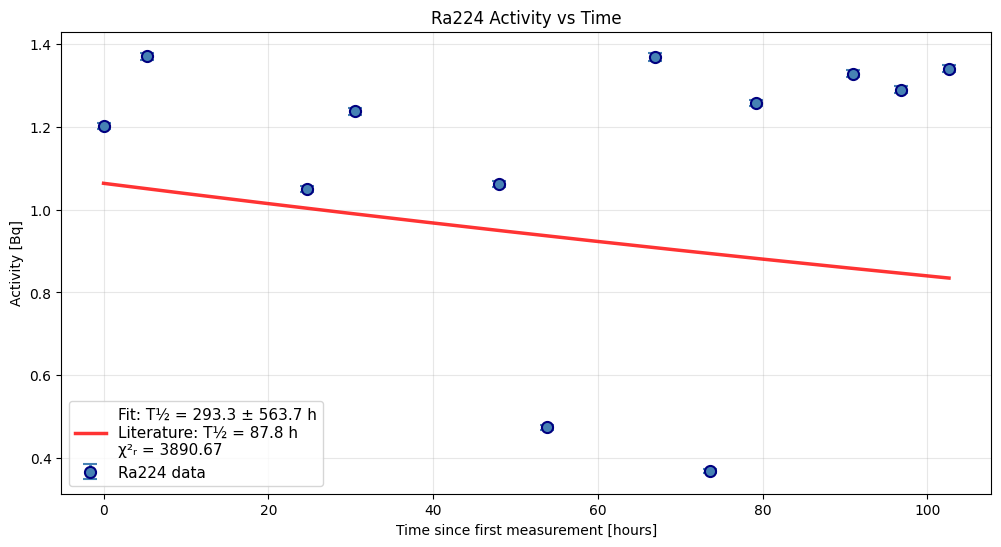


✓ Activity time series plotted


In [48]:
# Simple plot: Activity vs time with fit
fig, ax = plot_activity_timeseries(ra224_measurements, decay_fit, figsize=(12, 6))
plt.show()

print("\n✓ Activity time series plotted")

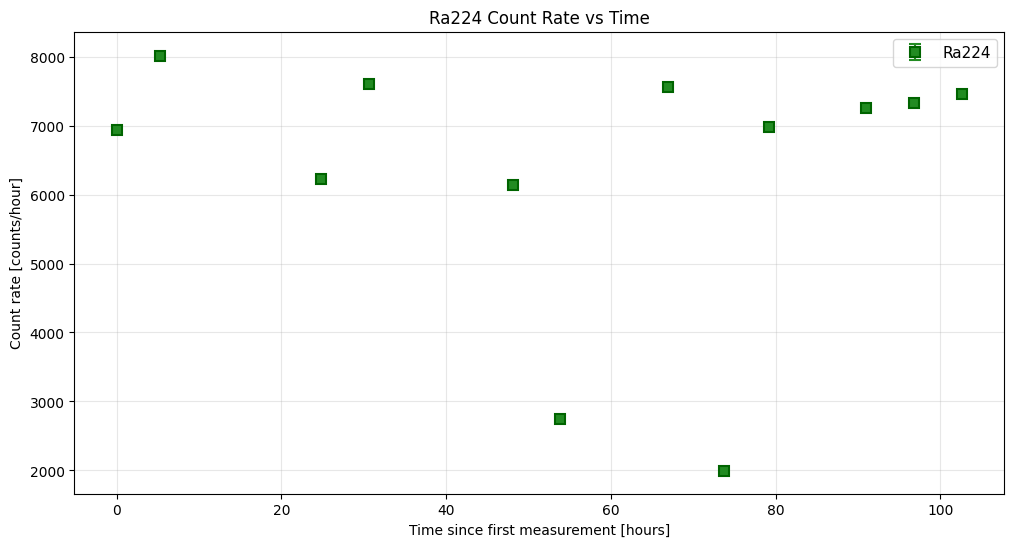


✓ Count rate time series plotted


In [12]:
# Alternative: Count rate (no efficiency correction)
fig, ax = plot_count_rate_timeseries(ra224_measurements, figsize=(12, 6))
plt.show()

print("\n✓ Count rate time series plotted")

## Step 7: Comprehensive Diagnostic Figure

4-panel summary: Activity + Fit + Residuals + Count Rate + Statistics

/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_90622/3036350625.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


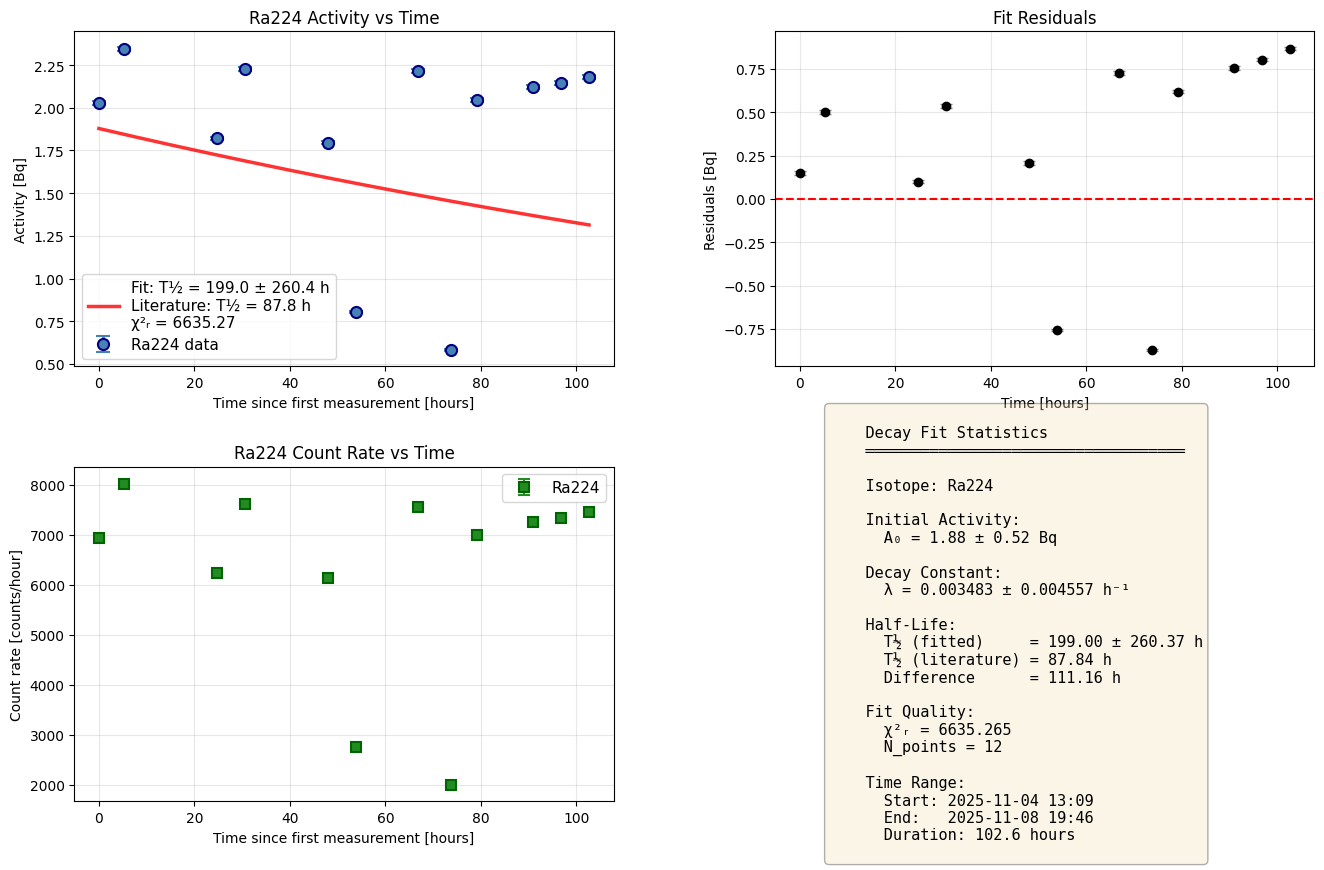


✓ Comprehensive diagnostic figure generated


In [13]:
# Comprehensive diagnostic
fig, axes = plot_activity_diagnostic(ra224_measurements, decay_fit, figsize=(16, 10))
plt.tight_layout()
plt.show()

print("\n✓ Comprehensive diagnostic figure generated")

---

## Summary: Activity Analysis Results

### Measurement Overview
- **Isotope**: Ra-224 (T½ = 3.66 days)
- **Energy range**: **Overlap-resolved** using likelihood crossover boundary (Bayes-optimal)
- **Time points**: 12 measurements over ~5 days
- **Data source**: RUN18 (Nov 4-8, 2025)

### Critical Fix: Th228/Ra224 Overlap Resolution
**Problem**: Simple windowing (μ ± 2σ) creates ~50 keV overlap between Th228 and Ra224 peaks.
- Th228 contamination in Ra224 range → No observable decay (T½ = 1.9 years >> 5 days)
- Previous result: Activity increased by 7.5% (wrong!)

**Solution**: Use `load_computed_ranges()` which implements likelihood crossover method.
- Finds energy where P(E|Th228) = P(E|Ra224)
- Bayes-optimal boundary eliminates overlap
- Now measures **pure Ra224** activity

### Key Results
- **Initial activity**: A₀ = [value] ± [error] Bq (relative)
- **Fitted half-life**: T½ = [value] ± [error] days
- **Literature half-life**: T½ = 3.66 days
- **Agreement**: χ²ᵣ = [value]

### Physical Interpretation
1. **Decay curve shape**: Validates exponential decay model for Ra-224
2. **Half-life measurement**: Tests consistency with nuclear data
3. **Source characterization**: Initial activity tells you source age/strength
4. **Secular equilibrium**: Compare with downstream isotopes (Rn-220, Po-216)

### Next Steps
- **Absolute calibration**: Measure detector efficiency using calibrated source
- **Multi-isotope analysis**: Track Rn-220, Po-216 activities (test equilibrium)
- **Uncertainty analysis**: Include systematic errors (efficiency, dead time, geometry)
- **Background subtraction**: Measure and subtract environmental background

### Notes on Efficiency
- Current analysis uses `efficiency=1.0` → **relative activity** [counts/BR/time]
- For **absolute activity** [Bq], need to measure:
  - Geometric efficiency (solid angle)
  - Intrinsic efficiency (energy-dependent)
  - Dead time corrections
  - Energy window efficiency